# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [5]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [8]:
df = pd.read_csv('./homework_6_texts_tursunov/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
11731,18031,62983,NaN,21-03-2020,COVID-19 and the Huge Battle with the Deaf &am...,Extremely Negative
19263,27245,72197,NaN,26-03-2020,fck me is there nothing Border Force amp this ...,Positive
11445,17673,62625,"Cape Town, South Africa",21-03-2020,Can @CyrilRamaphosa @DrZweliMkhize please regu...,Extremely Positive
671,4597,49549,"Los Angeles, CA",17-03-2020,Picture #01 \r\r\nYesterday last night me and ...,Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [15]:
df.loc[df['Sentiment'] == 'Negative', 'Sentiment'] = 0
df.loc[df['Sentiment'] == 'Extremely Negative', 'Sentiment'] = 0
df.loc[df['Sentiment'] == 'Positive', 'Sentiment'] = 1
df.loc[df['Sentiment'] == 'Extremely Positive', 'Sentiment'] = 1
df.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,1
5,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,1
6,3807,48759,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,1
7,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy th...",0
8,3810,48762,"Pitt Meadows, BC, Canada",16-03-2020,"Due to the Covid-19 situation, we have increas...",1
9,3811,48763,Horningsea,16-03-2020,#horningsea is a caring community. LetÃÂs AL...,1


Сбалансированы ли классы?

In [17]:
df.value_counts('Sentiment')

Sentiment
1    18046
0    15398
Name: count, dtype: int64

**Ответ:** Да, сбалансированны

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [19]:
df.isnull().sum()

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [22]:
df = df.fillna('Unknown')
df.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
2,3802,48754,Unknown,16-03-2020,My food stock is not the only one which is emp...,1
3,3803,48755,Unknown,16-03-2020,"Me, ready to go at supermarket during the #COV...",0
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,1
5,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,1
6,3807,48759,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,1
7,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy th...",0
8,3810,48762,"Pitt Meadows, BC, Canada",16-03-2020,"Due to the Covid-19 situation, we have increas...",1
9,3811,48763,Horningsea,16-03-2020,#horningsea is a caring community. LetÃÂs AL...,1


Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [35]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [89]:
from collections import Counter
tokens_counter = Counter([word.lower() for text in train['OriginalTweet'].to_numpy() for word in text.split()])

Какой размер словаря получился?

In [90]:
len(tokens_counter)

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [91]:
token_counter = sorted(tokens_counter.items(), reverse=True, key=lambda word: word[1])
token_counter[:10]

[('the', 26815),
 ('to', 23373),
 ('and', 14684),
 ('of', 13012),
 ('a', 11737),
 ('in', 11198),
 ('for', 8566),
 ('#coronavirus', 8223),
 ('is', 7383),
 ('are', 7050)]

**Ответ:** Это предлоги, они встречаются чаще всего

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [92]:
import nltk
nltk.download("stopwords", quiet=True)

True

In [93]:
from nltk.corpus import stopwords
token_counter = [word for word in token_counter if word[0] not in stopwords.words("english")]
token_counter[:10]

[('#coronavirus', 8223),
 ('prices', 3891),
 ('food', 3820),
 ('grocery', 3469),
 ('supermarket', 3288),
 ('people', 3175),
 ('covid-19', 3173),
 ('store', 3155),
 ('#covid19', 2471),
 ('&amp;', 2314)]

**Ответ:** Уже лучше, можно сказать, что волнует людей больше всего

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [94]:
token_counter[-20:]

[('skellig', 1),
 ('coast!', 1),
 ('closer!)', 1),
 ('@skelligsix18', 1),
 ('#skelligcoast2kms', 1),
 ('#southkerry', 1),
 ('https://t.co/zjcl195vqs', 1),
 ('@srinivasiyc', 1),
 ('https://t.co/iaek4fwsgz', 1),
 ('premiership', 1),
 ('non-playing', 1),
 ('subsidise', 1),
 ('playersã\x82â\x92', 1),
 ('renewing', 1),
 ('wage!', 1),
 ('flew', 1),
 ('nothing...', 1),
 ('@torontopearson', 1),
 ('@680news', 1),
 ('https://t.co/7j2y3rsld9', 1)]

**Ответ:** Здесь мелькают ссылки, никнеймы людей, достаточно странные хештеги. Такой мусорной информации много, она сильно будет замедлять модель

Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [106]:
from nltk.tokenize import TweetTokenizer
tweet_token = TweetTokenizer()
token_counter = Counter([word.lower() for text in train['OriginalTweet'].to_numpy() for word in tweet_token.tokenize(text)])

token_counter = sorted(token_counter.items(), reverse=True, key=lambda word: word[1])
token_counter[:10]

[('the', 26993),
 ('.', 24118),
 ('to', 23478),
 (',', 17571),
 ('and', 14825),
 ('of', 13044),
 ('a', 11891),
 ('in', 11348),
 ('?', 9524),
 ('#coronavirus', 8808)]

**Ответ:** Помимо артиклей появились знаки препинания, потому что теперь мы не просто по пробелу отделяем, а ещё и по знакам препинания

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [107]:
from string import punctuation

token_counter = [word for word in token_counter if word[0] not in stopwords.words("english") and word[0] not in punctuation]
token_counter[:10]

[('#coronavirus', 8808),
 ('â', 7415),
 ('\x82', 7311),
 ('19', 7167),
 ('covid', 6253),
 ('prices', 4601),
 ('\x92', 4372),
 ('food', 4367),
 ('store', 3877),
 ('supermarket', 3805)]

**Ответ:** Тут появились какие-то странные символы и число 19

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [108]:
token_counter = [word for word in token_counter if len(word[0]) != 1 or ord(word[0]) < 128]
token_counter[:10] # ТОП-10 популярных

[('#coronavirus', 8808),
 ('19', 7167),
 ('covid', 6253),
 ('prices', 4601),
 ('food', 4367),
 ('store', 3877),
 ('supermarket', 3805),
 ('grocery', 3523),
 ('people', 3463),
 ('#covid19', 2589)]

In [109]:
token_counter[-20:] # ТОП-20 непопулярных

[('https://t.co/lw1r0rm7xs', 1),
 ('https://t.co/5cbliqzx7l', 1),
 ('now.when', 1),
 ('milion', 1),
 ('skellig', 1),
 ('@skelligsix18', 1),
 ('#skelligcoast2kms', 1),
 ('#southkerry', 1),
 ('https://t.co/zjcl195vqs', 1),
 ('@srinivasiyc', 1),
 ('https://t.co/iaek4fwsgz', 1),
 ('premiership', 1),
 ('non-playing', 1),
 ('subsidise', 1),
 ('playersã', 1),
 ('renewing', 1),
 ('flew', 1),
 ('@torontopearson', 1),
 ('@680news', 1),
 ('https://t.co/7j2y3rsld9', 1)]

**Ответ:** ТОП популярных изменился незначительно, теперь слово "covid" и число 19 являются разными токенами, это скорее минус, так как число 19 само по себе не несёт никакой информации, а ТОП непопулярных перестал содежать слова, склеенные с пунктуацией, это плюс

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [113]:
[word for word in token_counter if word[0][0] == '#'][:10]

[('#coronavirus', 8808),
 ('#covid19', 2589),
 ('#covid_19', 1734),
 ('#covid2019', 946),
 ('#toiletpaper', 744),
 ('#covid', 641),
 ('#socialdistancing', 465),
 ('#coronacrisis', 448),
 ('#pandemic', 257),
 ('#coronaviruspandemic', 249)]

**Ответ:** все они об одном и том же (кроме туалетной бумаги и социального дистанцирования), в принципе их можно было бы объединить в 1 токен.

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [115]:
[word for word in token_counter if 'https://t.co' in word[0]][:10]

[('https://t.co/oxa7swtond', 5),
 ('https://t.co/gp3eusapl8', 4),
 ('https://t.co/deftrui1pfã\x82â', 3),
 ('https://t.co/wrlhyzizaa', 3),
 ('https://t.co/kuwipf1kqw', 3),
 ('https://t.co/zjnrx6dkkn', 3),
 ('https://t.co/3gbbdpdjat', 3),
 ('https://t.co/e2znxajpre', 3),
 ('https://t.co/catkegayoy', 3),
 ('https://t.co/g63rp042ho', 3)]

**Ответ:** популярность хештегов и ссылок очень отличается, информация о ссылке не будет полезна, так как очень редко встречается

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [141]:
def custom_tokenizer(text):
    tweet_token = TweetTokenizer()
    text = text.lower()
    token_counter = Counter([word for word in tweet_token.tokenize(text) if word not in punctuation and word not in stopwords.words("english") and (len(word) != 1 or ord(word) < 128) and 'https://t.co' not in word])

    return list(token_counter.keys())

In [142]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [143]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
cv.fit_transform(train['OriginalTweet'])

print(len(cv.vocabulary_))

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45306


**Ответ:** Он получился меньше, так как много лишнего убрали

Посмотрим на какой-нибудь конкретный твитт:

In [144]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [162]:
token_counter = sorted(list(zip(cv.get_feature_names_out(), *cv.transform([train.iloc[ind]['OriginalTweet']]).toarray())), key=lambda word: word[1])
print(f'Самый популярный: {token_counter[-1]}')
for word in token_counter:
    if word[1] != 0:
        print(f'Самый непопулярный: {word}')
        break

Самый популярный: ('show', 1)
Самый непопулярный: ('#coronavirusoutbreak', 1)


**Ответ:** Плохо определились, потому что только по 1 разу встретились в тексте

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [163]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(tokenizer=custom_tokenizer)
tv.fit_transform(train['OriginalTweet'])

token_counter = sorted(list(zip(tv.get_feature_names_out(), *tv.transform([train.iloc[ind]['OriginalTweet']]).toarray())), key=lambda word: word[1])
print(f'Самый популярный: {token_counter[-1]}')
for word in token_counter:
    if word[1] != 0:
        print(f'Самый непопулярный: {word}')
        break

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Самый популярный: ('brainless', 0.3867641170466375)
Самый непопулярный: ('food', 0.11328893069250721)


**Ответ:** Да, токены определились хорошо, слово "brainless" ярко выражает эмоцианальную окраску твита, а слово "food" является достаточно безэмоциональным

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [172]:
train[train['OriginalTweet'].apply(lambda x: 'wonderful' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
20160,28380,73332,London/Dorking,26-03-2020,"@caitlinmoran Brilliant, but how about showing...",1
5274,10212,55164,"London, England",19-03-2020,So grateful to @POTAGELONDON today. Not only w...,1
3747,8344,53296,VA,18-03-2020,Sad sign of the times: Just before the alarm w...,1
19432,27458,72410,ADHS 67 Algonquin Civil 70,26-03-2020,Please be aware and give everyone their space ...,1
31953,43102,88054,"Scotland, United Kingdom",12-04-2020,I understand and get the wonderful job the sup...,1
2587,6928,51880,UK,18-03-2020,Just what to say what a wonderful job @AldiUK ...,1
22910,31792,76744,United Kingdom,04-04-2020,amp are often most impacted by cirisis yet mos...,1
10014,15960,60912,Unknown,21-03-2020,With US grocery store shelves empty of TP Toil...,1
22786,31645,76597,"Madison, WI, US, 53719",03-04-2020,Stickley furniture is built to withstand gener...,1
14975,22007,66959,Unknown,23-03-2020,. I spoke to local business owners hillside Av...,1


In [183]:
ind = 31953
token_counter = sorted(list(zip(tv.get_feature_names_out(), *tv.transform([train.loc[ind]['OriginalTweet']]).toarray())), key=lambda word: word[1])
print(f'Самый популярный: {token_counter[-1]}')
for word in token_counter:
    if word[1] != 0:
        print(f'Самый непопулярный: {word}')
        break
train.loc[ind]['OriginalTweet']

Самый популярный: ('fekking', 0.31376156537120725)
Самый непопулярный: ('prices', 0.08136407772122227)


'I understand and get the wonderful job the supermarkets are doing right now, and its greatly appreciated too. But whats with the fekking price increases as people struggle! Prices creeping up and up. #supermarketbands #priceincrease #EasterSunday #COVID__19'

**Ответ:** Эмоциональная окраска слова "fekking" действительно большая, а слово "prices" достаточно общеупотребимое

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [186]:
y_train = train['Sentiment']
X_train = train.drop(columns = ['Sentiment'])

y_test = test['Sentiment']
X_test = test.drop(columns = ['Sentiment'])

train_cv_vectorized = cv.fit_transform(X_train['OriginalTweet'])
train_tv_vectorized = tv.fit_transform(X_train['OriginalTweet'])

test_cv_vectorized = cv.transform(X_test['OriginalTweet'])
test_tv_vectorized = tv.transform(X_test['OriginalTweet'])

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [189]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_cv = LogisticRegression(max_iter=10000)
lr_tv = LogisticRegression(max_iter=10000)

lr_cv.fit(train_cv_vectorized, y_train)
lr_tv.fit(train_tv_vectorized, y_train)

print(f'Точность на TRAIN при CountVectoriser: {accuracy_score(y_train, lr_cv.predict(train_cv_vectorized))}')
print(f'Точность на TEST при CountVectoriser: {accuracy_score(y_test, lr_cv.predict(test_cv_vectorized))}')
print(f'Точность на TRAIN при TfidfVectorizer: {accuracy_score(y_train, lr_tv.predict(train_cv_vectorized))}')
print(f'Точность на TEST при TfidfVectorizer: {accuracy_score(y_test, lr_tv.predict(test_cv_vectorized))}')

Точность на TRAIN при CountVectoriser: 0.982913284920974
Точность на TEST при CountVectoriser: 0.8659557504484752
Точность на TRAIN при TfidfVectorizer: 0.8779154207603588
Точность на TEST при TfidfVectorizer: 0.8290811241777954


**Ответ:** CountVectoriser показал лучший результат, модели проявляют себя неплохо

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [192]:
from nltk.stem.snowball import SnowballStemmer
def custom_stem_tokenizer(text):
    stemmer = SnowballStemmer("english")
    tweet_token = TweetTokenizer()
    text = text.lower()
    token_counter = Counter([stemmer.stem(word) for word in tweet_token.tokenize(text) if word not in punctuation and word not in stopwords.words("english") and (len(word) != 1 or ord(word) < 128) and 'https://t.co' not in word])

    return list(token_counter.keys())

In [193]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [194]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
cv.fit_transform(train['OriginalTweet'])

print(len(cv.vocabulary_))

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36650


**Ответ** Словарь стал меньше, так как стемминг объединяет почти одинаковые слова

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [195]:
train_cv_stem = cv.fit_transform(X_train['OriginalTweet'])
test_cv_stem = cv.transform(X_test['OriginalTweet'])

In [197]:
lr_cv_stem = LogisticRegression(max_iter=10000)
lr_cv_stem.fit(train_cv_stem, y_train)
print(f'Точность на TRAIN при CountVectoriser + STEM: {accuracy_score(y_train, lr_cv_stem.predict(train_cv_stem))}')
print(f'Точность на TEST при CountVectoriser + STEM: {accuracy_score(y_test, lr_cv_stem.predict(test_cv_stem))}')

Точность на TRAIN при CountVectoriser + STEM: 0.968859461768475
Точность на TEST при CountVectoriser + STEM: 0.8644608331672314


**Ответ:** Точность чуть-чуть упала, но скорость работы модели выросла, стемминг имеет смысл применять при большом объёме данных, когда нужно быстрее обучить модель

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [204]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df=8000).fit(train['OriginalTweet'])
print(len(cv_df.vocabulary_)) # у меня изначальный словарь на 2 меньше вашего, поэтому получится 36649

36649


**Ответ:** Большой, потому что мы отрезали самый часто встречающийся

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [209]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=11).fit(train['OriginalTweet'])
print(len(cv_df.vocabulary_)) # Здесь надо 3699

3700


In [210]:
train_cv_df_stem = cv_df.fit_transform(X_train['OriginalTweet'])
test_cv_df_stem = cv_df.transform(X_test['OriginalTweet'])

In [211]:
lr_cv_df_stem = LogisticRegression(max_iter=10000)
lr_cv_df_stem.fit(train_cv_df_stem, y_train)
print(f'Точность на TRAIN при CountVectoriser + STEM: {accuracy_score(y_train, lr_cv_df_stem.predict(train_cv_df_stem))}')
print(f'Точность на TEST при CountVectoriser + STEM: {accuracy_score(y_test, lr_cv_df_stem.predict(test_cv_df_stem))}')

Точность на TRAIN при CountVectoriser + STEM: 0.9250747543784708
Точность на TEST при CountVectoriser + STEM: 0.8633645604943193


**Ответ:** Результаты стали хуже, но модель работает гораздо быстрее

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [215]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
scaler.fit(train_cv_df_stem)

train_scaled_stem = scaler.transform(train_scaled_stem)
test_scaled_stem = scaler.transform(test_scaled_stem)

lr_scaled_stem = LogisticRegression(max_iter=10000)
lr_scaled_stem.fit(train_scaled_stem, y_train)
print(f'Точность на TRAIN при CountVectoriser + STEM: {accuracy_score(y_train, lr_scaled_stem.predict(train_scaled_stem))}')
print(f'Точность на TEST при CountVectoriser + STEM: {accuracy_score(y_test, lr_scaled_stem.predict(test_scaled_stem))}')

Точность на TRAIN при CountVectoriser + STEM: 0.9394275950448526
Точность на TEST при CountVectoriser + STEM: 0.841837751644409


**Ответ:** Результат ухудшился, а токены ниже вполне закономерно входят в ТОП-10, потому что несут в себе яркую эмоциональную окраску

<Axes: xlabel='word', ylabel='value'>

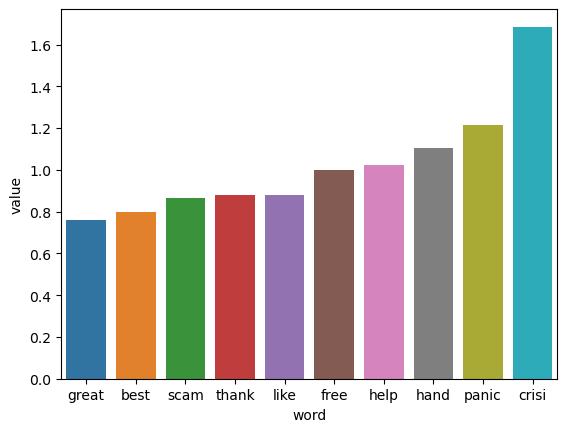

In [234]:
w = lr_scaled_stem.coef_.reshape(-1)
df_wv = pd.DataFrame({"word": cv_df.get_feature_names_out(), 'value': abs(w)}).sort_values(by='value')
sns.barplot(x='word', y='value', data=df_wv[-10:], hue='word')

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [ ]:
# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [ ]:
# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [ ]:
# -- YOUR CODE HERE --

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

In [ ]:
# -- YOUR CODE HERE --

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [ ]:
# -- YOUR CODE HERE --

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [ ]:
# -- YOUR CODE HERE --

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [ ]:
# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

In [ ]:
# -- YOUR CODE HERE --